# LFP Analysis Practice

import libs 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import math 
import pickle
import os 
import scipy.signal as signal 
from matplotlib.pyplot import mlab 
import neurodsp as neuro

initalize variables 

In [4]:
LFP_file = '2022-06-24_NSD_CA1_24hrs_1250Hz.lfp'
LFP_file_stats = os.stat(LFP_file)
num_bytes = LFP_file_stats.st_size
num_channels = 256
bytes_per_channel = num_bytes / num_channels
samples_per_channel = bytes_per_channel / 2
fs = 1250
startSec = int(1e4)
startSample = fs  * startSec
recordTime = samples_per_channel
print(f"Total bytes = {num_bytes}")
print(f"Bytes per channel = {bytes_per_channel}")
print(f"Samples per channel = {samples_per_channel}")
print(f"Time of recording = {samples_per_channel / 1250}")

Total bytes = 47813097472
Bytes per channel = 186769912.0
Samples per channel = 93384956.0
Time of recording = 74707.9648


create a memory map object 
- shape = 256 x numSamples
- type = int16

In [5]:
LFP_data = np.memmap(filename = LFP_file, dtype = 'int16', mode = 'r', offset = 0 ,shape = (num_channels,int(samples_per_channel)), order = 'F')

pull a 1 second bit of signal from any channel as a sample signal to work with

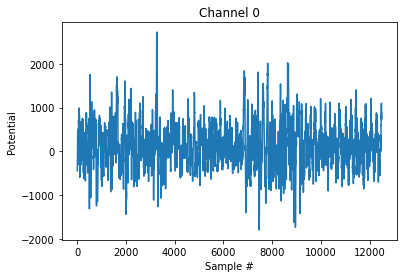

In [6]:
plt.plot(LFP_data[0][startSample:(startSample + 10*int(fs))])
plt.xlabel("Sample #")
plt.title("Channel 0")
plt.ylabel("Potential")
plt.show()

plot the LFP for 4 channels of the channels 

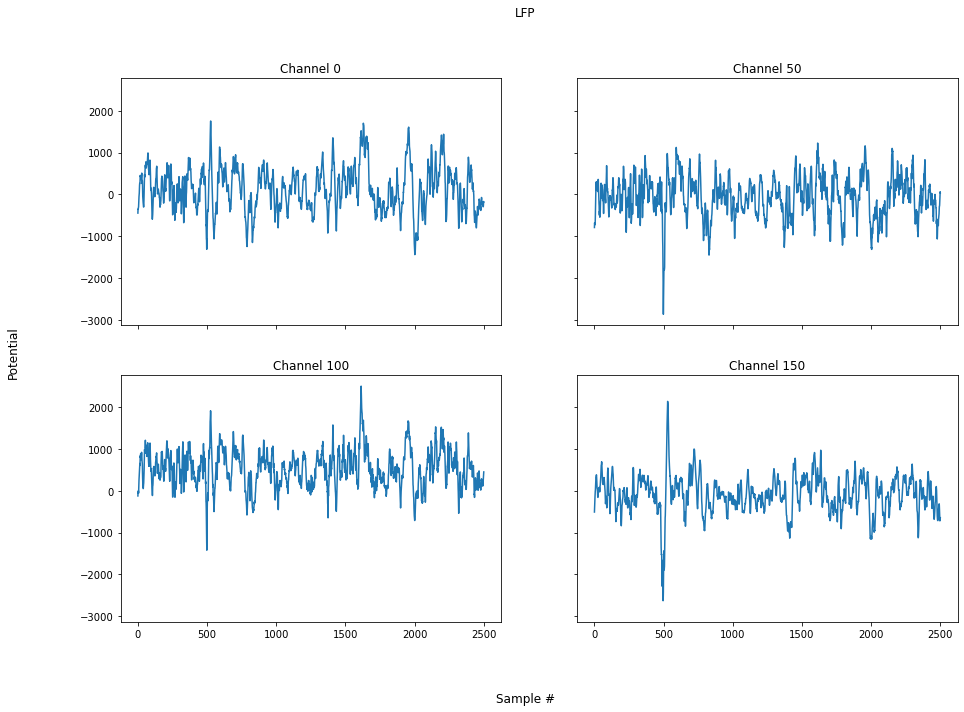

In [7]:
fig1, axs1 = plt.subplots(2,2, sharex = True, sharey = True)
for i in range(0,2):
    for j in range(0,2):
        axs1[i,j].plot(LFP_data[i*100+ j*50][startSample:startSample + fs*2])
        axs1[i,j].set_title('Channel ' + str(i*100+j*50))
fig1.supxlabel('Sample #')
fig1.supylabel("Potential")
fig1.suptitle("LFP")
fig1.set_figwidth(15)
fig1.set_figheight(10)

plot power spectrum of the LFP signals over 10s using scipy periodogram

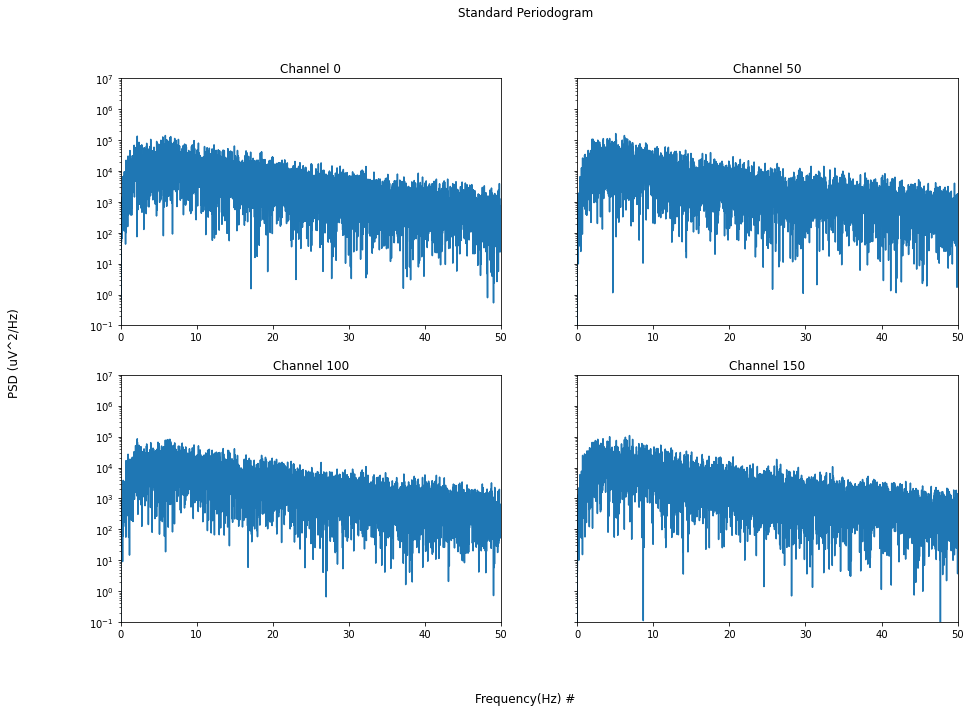

In [8]:
fig2, axs2 = plt.subplots(2,2, sharex = False, sharey = True)
for i in range(0,2):
    for j in range(0,2):
        #10 seconds of data
        (f,S) = signal.periodogram(x = LFP_data[100*i+50*j][startSample:startSample + fs*100], fs = fs, scaling = "density")
        axs2[i,j].semilogy(f,S)
        axs2[i,j].set_title('Channel ' + str(100*i+50*j))
        axs2[i,j].set_xlim(0,50)
        axs2[i,j].set_ylim(1e-1,1e7)
fig2.supxlabel('Frequency(Hz) #')
fig2.supylabel("PSD (uV^2/Hz)")
fig2.suptitle("Standard Periodogram")
fig2.set_figheight(10)
fig2.set_figwidth(15)

plot the psd using the matplotlib.psd - uses a Welch's average periodogram method, uses overlap between FFT segments to be analyzed

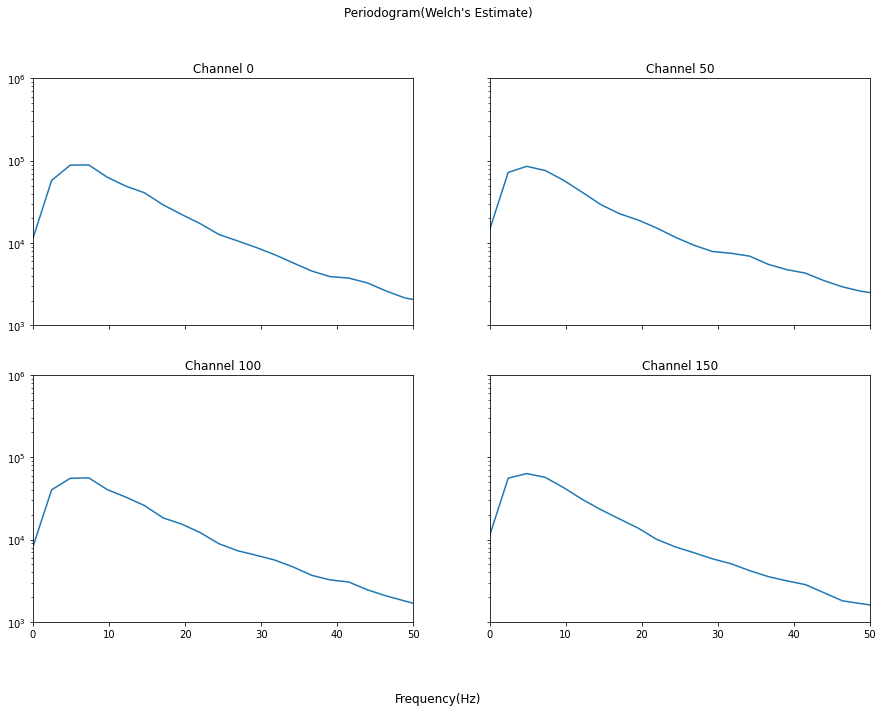

In [9]:
fig4,axs4 = plt.subplots(2,2,sharey = True, sharex = True)
for i in range (0,2):
    for j in range(0,2):
        sig_sample =  LFP_data[i*100+j*50][startSample: startSample + fs*100]
        (f,Pxx) = signal.welch(x = sig_sample, fs = fs, window = 'hann',nperseg = 512, scaling = 'spectrum')
        axs4[i,j].semilogy(f,Pxx)
        axs4[i,j].set_title(f"Channel {i*100+j*50}")
        axs4[i,j].set_xlim(0,50)
        axs4[i,j].set_ylim(1e3,1e6)

    
fig4.suptitle("Periodogram(Welch's Estimate)")
fig4.supxlabel("Frequency(Hz)")
fig4.set_figheight(10)
fig4.set_figwidth(15)

        

Welch's estimate(mean) using neurodsp library

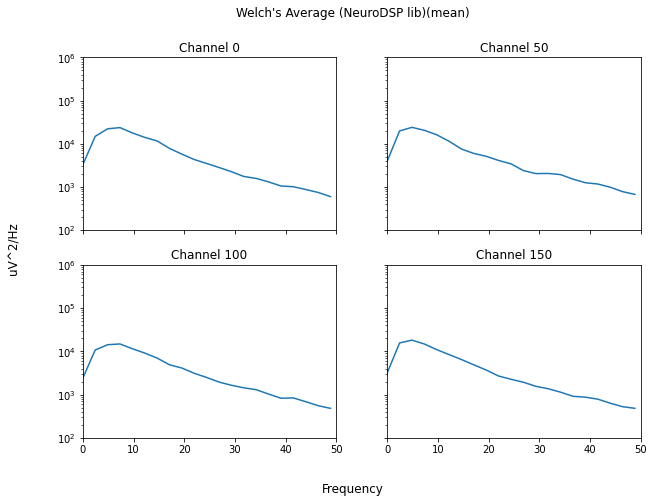

In [10]:
#compute the power spectrum, pass in the same sample 
from neurodsp.spectral import compute_spectrum_welch
fig,axs = plt.subplots(2,2, figsize = (10,7),sharex=True, sharey=True)
fig.suptitle("Welch's Average (NeuroDSP lib)(mean)")
fig.supxlabel('Frequency')
fig.supylabel('uV^2/Hz')
for i in range (0,2):
    for j in range(0,2):
        sig_sample =  LFP_data[i*100+j*50][startSample: startSample + fs*100]
        freqs_welch_mean, spectrum_welch_mean = compute_spectrum_welch(sig = sig_sample, fs = fs, avg_type = 'mean', window = 'hann', nperseg = 512, f_range = [0,50])
        axs[i,j].set_title(f"Channel {i*100+j*50}")
        axs[i,j].semilogy(freqs_welch_mean, spectrum_welch_mean)
        axs[i,j].set_xlim(0,50)
        axs[i,j].set_ylim(1e2,1e6)

Welch's estimate(median) using neurodsp library

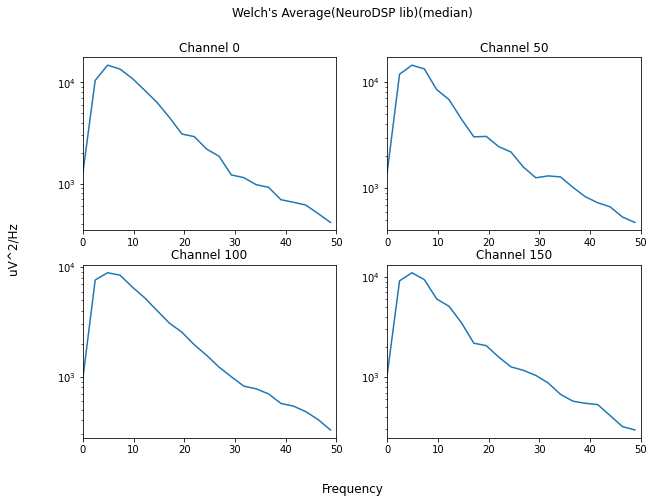

In [11]:
fig,axs = plt.subplots(2,2, figsize = (10,7))
fig.suptitle("Welch's Average(NeuroDSP lib)(median)")
fig.supxlabel('Frequency')
fig.supylabel('uV^2/Hz')
for i in range (0,2):
    for j in range(0,2):
        sig_sample =  LFP_data[i*100+j*50][startSample: startSample + fs*100]
        freqs_welch_med, spectrum_welch_med = compute_spectrum_welch(sig = sig_sample, fs = fs, avg_type = 'median', window = 'hann', nperseg = 512, f_range = [0,50])
        axs[i,j].set_title(f"Channel {i*100+j*50}")
        axs[i,j].semilogy(freqs_welch_med, spectrum_welch_med)
        axs[i,j].set_xlim(0,50)

Wavelet Transform using neurodsp library - Discrete WT 

KeyboardInterrupt: 

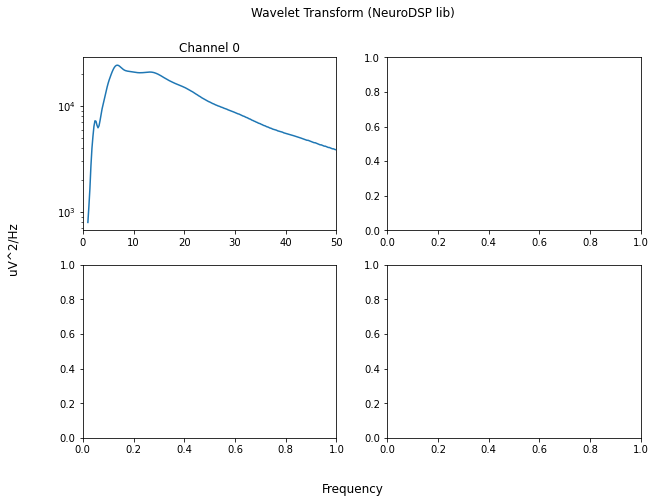

In [12]:
from neurodsp.spectral import compute_spectrum_wavelet
fig,axs = plt.subplots(2,2, figsize = (10,7))
fig.suptitle("Wavelet Transform (NeuroDSP lib)")
fig.supxlabel('Frequency')
fig.supylabel('uV^2/Hz')
for i in range (0,2):
    for j in range(0,2):
        sig_sample =  LFP_data[i*100+j*50][startSample: startSample + fs*100]
        freqs_wavelet_mean, spectrum_wavelet_mean = compute_spectrum_wavelet(sig = sig_sample, fs = fs, avg_type = 'mean', freqs = [1,50,0.2])
        axs[i,j].set_title(f"Channel {i*100+j*50}")
        axs[i,j].semilogy(freqs_wavelet_mean, spectrum_wavelet_mean)
        axs[i,j].set_xlim(0,50)

 # Neural Signal Paramaterization using FOOOF
 - fit periodic and aperiodic components of the LFP signal's power spectrum 
 - convert the periodic fit back to time domain using reverse fourier transform of the signal


In [ ]:
from  fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate  import plot_annotated_model
#create the fooof object to fit the neural power parameters
fm = FOOOF(verbose = True)
#fit,print results, and plot the fit applied to the power spectrum
fm.report(freqs_welch_mean, spectrum_welch_mean, freq_range= [2,50])

# Spectral Whitening
 - fit an Auto Regressive model to the signal --> subtract noise term from the signal to obtain whitened signal for clearer time-freuqency viualizations

In [29]:
from statsmodels.tsa.ar_model import AutoReg

def whiten_signal(sig,lags_in):
    #pad the signal(add the number of lags to be used as a pad for the start)
    padded_sig = np.pad(array = sig, pad_width = (lags_in,0),mode = 'constant', constant_values = 0)
    #create the AutoRegressive Model 
    fitted_model = AutoReg(endog = padded_sig, lags = lags_in, old_names = False).fit()
    #fit the model - extract the predictions from the second index and on (exclude the padded elements)
    predictions = fitted_model.predict(start = 0 , end = len(padded_sig) - 1)[lags_in:]
    whitened_sig = sig - predictions 

    return whitened_sig

(0.0, 50.0)

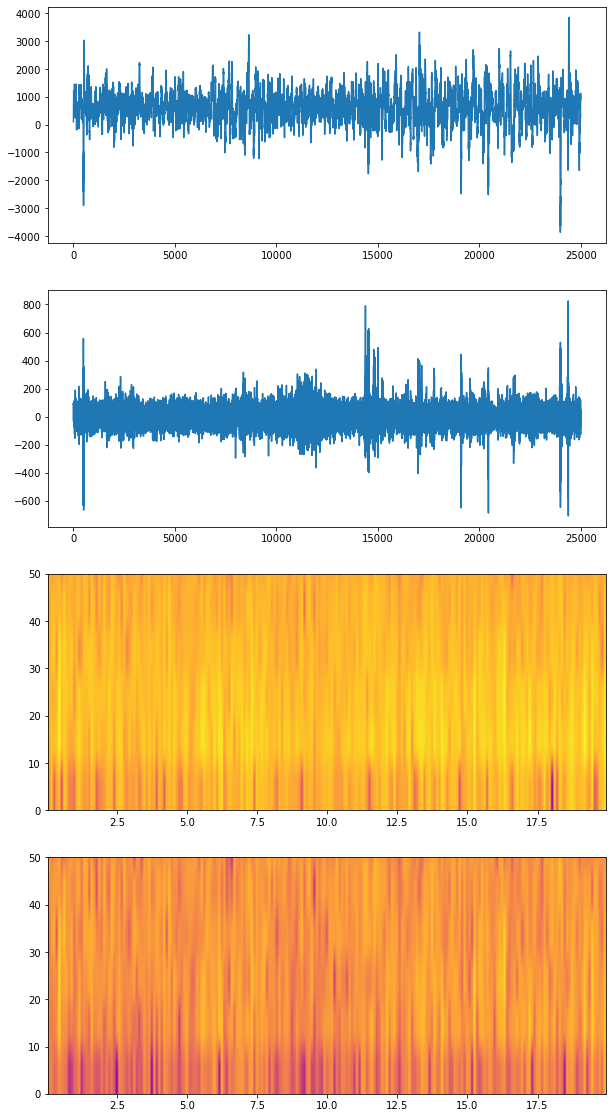

In [31]:
fig, axs = plt.subplots(4,1,figsize = (10,20))
sig_sample = LFP_data[200][startSample: startSample + fs*20 + 1]
#obtain a whitended version of the signal(autoregressive model)
whitened_sig_sample = whiten_signal(sig = sig_sample, lags_in= 2)

t = np.linspace(0,len(sig_sample),len(sig_sample))
#plot the original signal
axs[0].plot(t,sig_sample)
#plot whitended signal 
axs[1].plot(t,whitened_sig_sample)

#create the spectrogram for each and compare
f_og, t_og, Sxx_og = signal.spectrogram(x = sig_sample, fs = fs, window = 'hann',nperseg = 128, scaling = 'density' )
f_white , t_white, Sxx_white = signal.spectrogram(x = whitened_sig_sample, fs = fs ,window = 'hann', nperseg = 128,scaling = 'density')

axs[2].imshow(np.log(Sxx_og),cmap = 'plasma', origin = 'lower',aspect = 'auto', extent = [t_og[0],t_og[-1],f_og[0],f_og[-1]])
axs[2].set_ylim(0,50)
axs[3].imshow(np.log(Sxx_white),cmap = 'plasma', origin = 'lower',aspect = 'auto',extent = [t_white[0],t_white[-1], f_white[0], f_white[-1]])
axs[3].set_ylim(0,50)

# Time Frequency Analysis

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

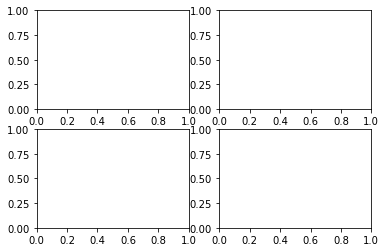

In [33]:
fig3,axs3 = plt.subplots(2,2)
for i in range(0,2):
    for j in range(0,2):
        #pull the signal sample
        sig_sample = LFP_data[i*100+j*50][startSample: startSample + fs*10 + 1]
        #obtain a whitended version of the signal(autoregressive model)
        whitened_sig_sample = whiten_signal(sig = sig_sample, lags_in= 2)
        #plot them 
        t = np.linspace(0,len(sig_sample))
        axs[i,j].plot(t,sig_sample)
        #create the spectrogram --> returns an image using imshow
        f_og, t_og, Sxx_og = signal.spectrogram(x = sig_sample, fs = fs, window = 'hann',nperseg = 256, scaling = 'density' )
        f_white , t_white, Sxx_white = signal.spectrogram(x = whitened_sig_sample, fs = fs ,window = 'hann', nperseg = 256,scaling = 'density')
        #plot the spectrogram arrays using pcolormesh/pcolor
        



        axs3[i,j].set_title(f"Channel {i*100+j*50}")
        axs3[i,j].set_ylim(0,50)
        axs3[i,j].set_ylabel("Frequency(Hz)")
        axs3[i,j].set_xlabel("Time")
cax = fig3.add_axes([.925,.1,0.02,.8])

fig3.colorbar(axs3[0,0].images[0], cax = cax)
plt.show()

# Time-Frequency Analysis using Morlet Wavelet Transform 

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

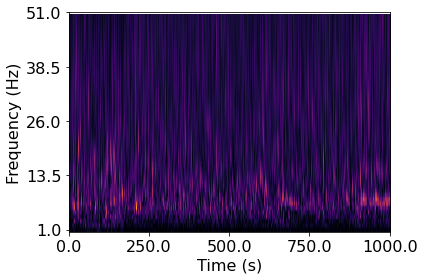

In [84]:
from neurodsp.plts import plot_timefrequency
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.utils import create_times
#pull the signal sample
sig_sample = LFP_data[100][startSample: startSample + fs*1000 + 1]
#compute the morlet wavelet transform, returning a 2d array of the power distribution of the signal temporally 
mws = compute_wavelet_transform(sig = sig_sample, fs = fs, freqs = np.linspace(1,51,50),n_cycles = 7)
plot_timefrequency(times = create_times(n_seconds = 1000,fs = fs),freqs = np.linspace(1,51,50),powers = mws,cmap = 'inferno')
plt.colorbar()







In [ ]:
import pywt 



# Why is 1/f power dynamics in biological signals a problem for time-frequency analysis?
- example - which has more power in a neural signal : freq. band in a lower band or higher band? - of course it will almost always be the lower freq. due to 1/f dynamics. (doesn't tell us anything)
- another example: suppose you want to know which band is generating more task-related frequency?(meaningful question with a meaningful answer)  - difficult to answer with the 1/f dynamics involved in the power spectrum
- 1/f is NOT an artifact - there can be diff. in 1/f dynamic differnces between young and old people(long term traits and dynamics)



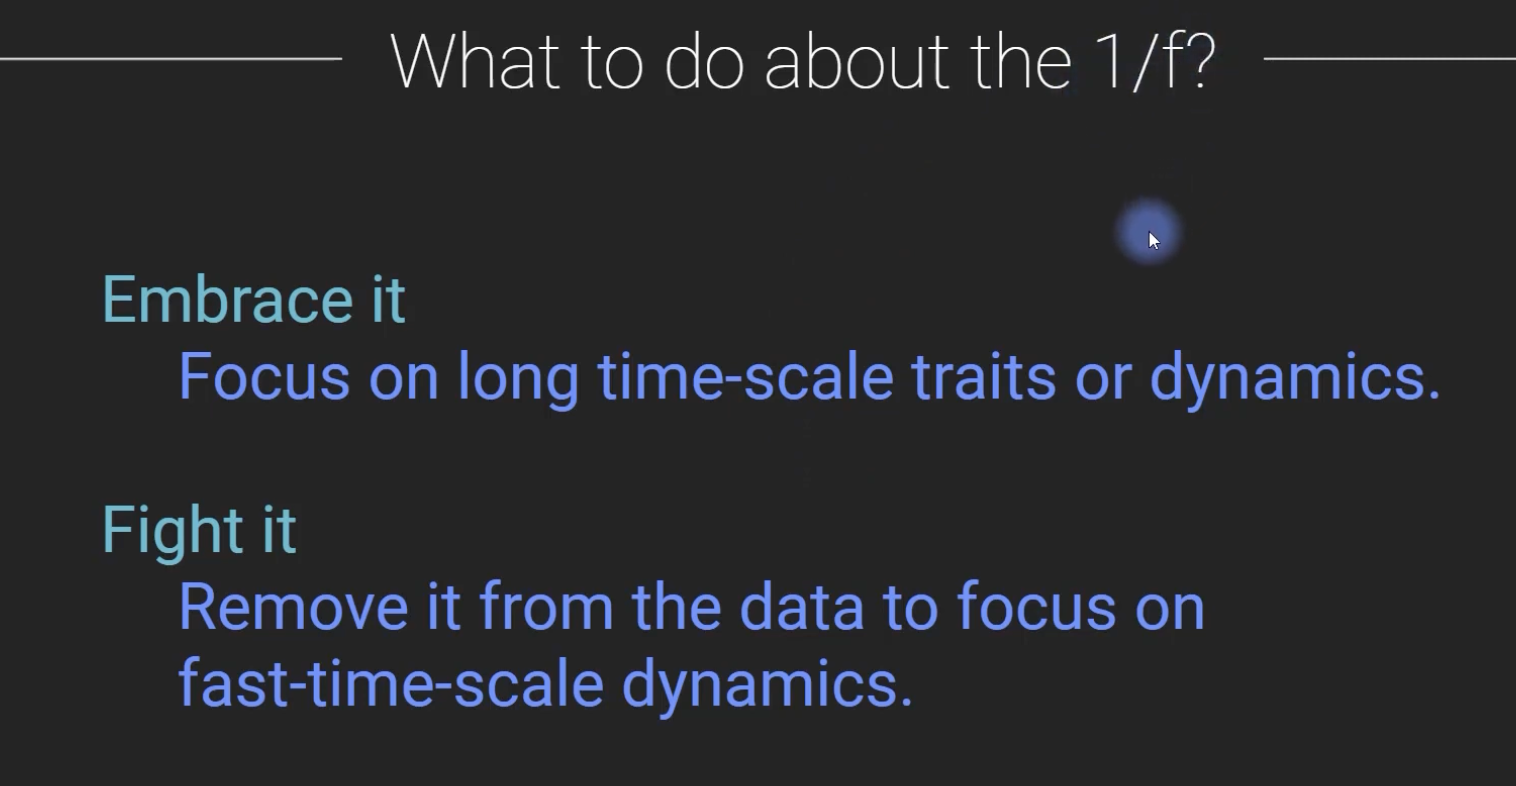

In [26]:
from IPython import display 
display.Image("/Users/elkinbayraktar/Desktop/Screen Shot 2023-07-10 at 11.12.02 AM.png", width = 600, height = 300)


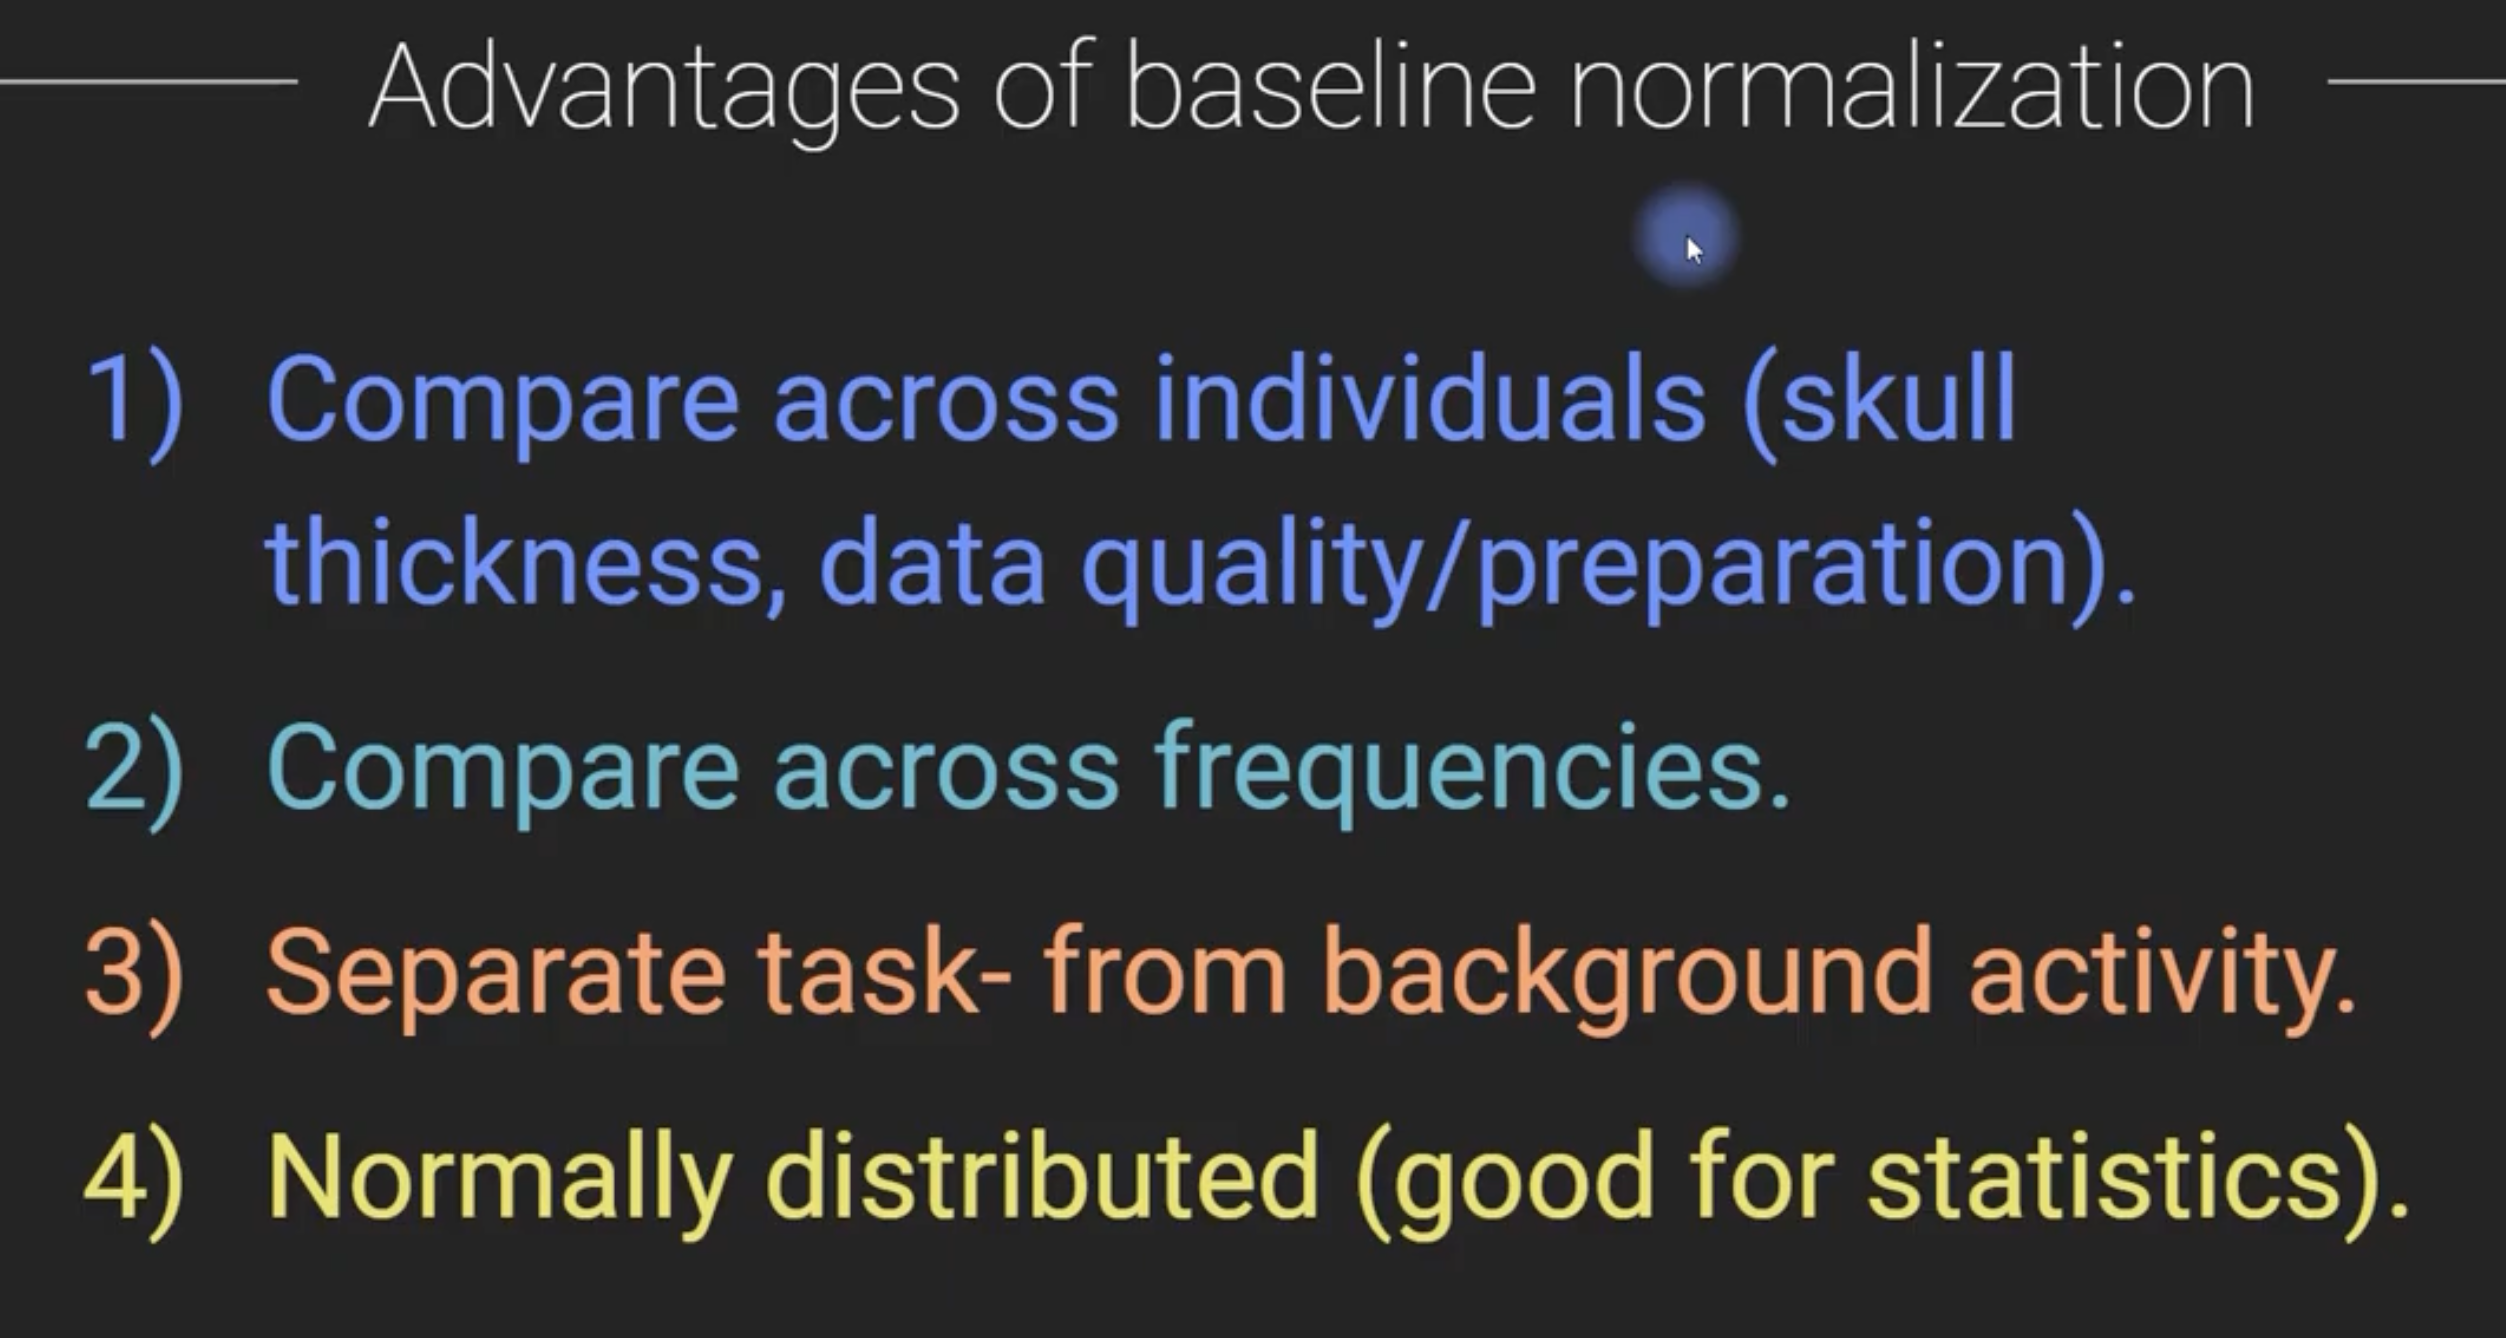

In [27]:
display.Image("/Users/elkinbayraktar/Desktop/Screen Shot 2023-07-10 at 12.04.20 PM.png", width=600, height=300)

remove the 1/f dynamics of the data to focus on fast-time scale dynamics of the signal, changes in the underlying 1/f bias are not of interest for our application ---> baseline normalization